In [1]:
!pip install transformers evaluate matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00


Label mapping: {'business': 0, 'entertainment': 1, 'tech': 2}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/5269 [00:00<?, ? examples/s]

Map:   0%|          | 0/1318 [00:00<?, ? examples/s]

Map:   0%|          | 0/1318 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B serve

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
100,0.257900,0.200683,0.930197
200,0.153400,0.312983,0.932473
300,0.208400,0.211148,0.939302
400,0.179700,0.275523,0.931715
500,0.108300,0.199921,0.938543
600,0.078200,0.256278,0.935508
700,0.086800,0.285441,0.936267
800,0.070900,0.289614,0.937785
900,0.049900,0.337148,0.941578
1000,0.036400,0.330192,0.938543


Evaluation on English validation set:


Accuracy on English validation set: 0.9385432473444613
Evaluation on Gujarati dataset:
Accuracy on Gujarati test data: 0.4355083459787557


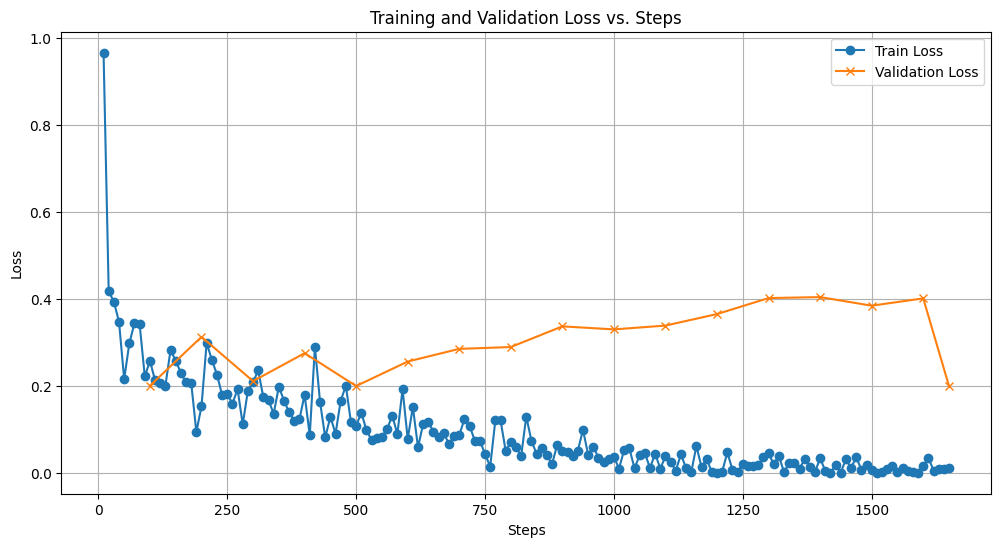

Train-Val Loss Saved!!


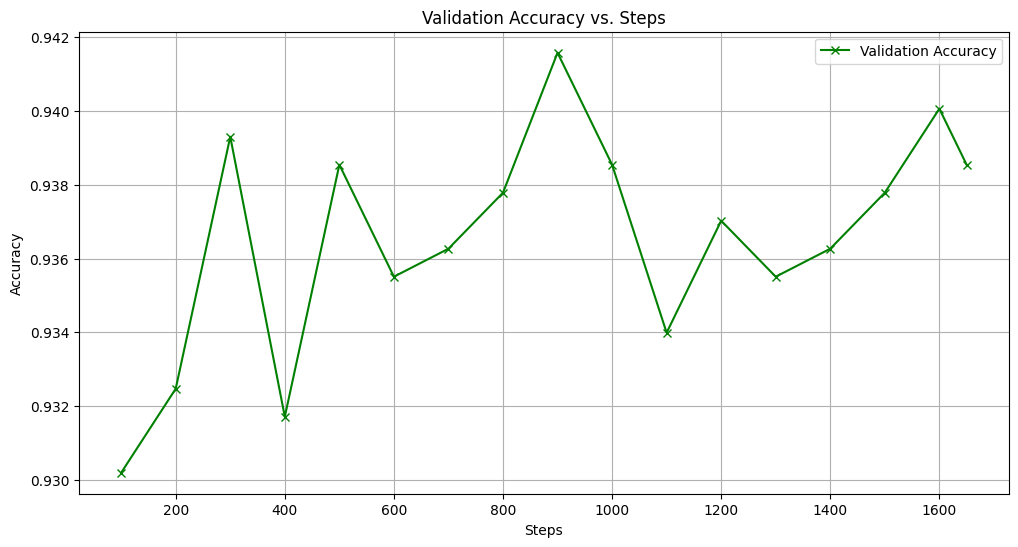

Validation Accuracy Plot Saved!!


In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import os


df_train = pd.read_csv("/kaggle/input/eng-guj/eng_guj_train.csv")
df_val = pd.read_csv("/kaggle/input/eng-guj/eng_guj_val.csv")


unique_labels = df_train['sentiment'].unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
print("Label mapping:", label_mapping)

df_train['sentiment'] = df_train['sentiment'].map(label_mapping)
df_val['sentiment'] = df_val['sentiment'].map(label_mapping)


train_texts = df_train['eng_text'].tolist()
train_labels = df_train['sentiment'].tolist()


val_texts = df_val['eng_text'].tolist()
val_labels = df_val['sentiment'].tolist()


guj_texts = df_val['guj_text'].tolist()
guj_labels = df_val['sentiment'].tolist()


model_name = "roberta-base"  
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=128
    )


train_dataset = Dataset.from_dict({'text': train_texts, 'labels': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'labels': val_labels})
guj_dataset = Dataset.from_dict({'text': guj_texts, 'labels': guj_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
guj_dataset = guj_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
guj_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


training_args = TrainingArguments(
    output_dir='/kaggle/working/results/roberta_guj',
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy='steps',
    eval_steps=100,
    save_steps=500,
    logging_dir='/kaggle/working/logs/roberta_guj',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,  
)


metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


num_labels = len(label_mapping)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


print("Evaluation on English validation set:")
eval_results = trainer.evaluate()
print(f"Accuracy on English validation set: {eval_results['eval_accuracy']}")


print("Evaluation on Gujarati dataset:")
guj_results = trainer.predict(guj_dataset)
guj_predictions = np.argmax(guj_results.predictions, axis=-1)
guj_accuracy = metric.compute(predictions=guj_predictions, references=guj_results.label_ids)
print(f"Accuracy on Gujarati test data: {guj_accuracy['accuracy']}")


train_logs = trainer.state.log_history


train_loss = [log['loss'] for log in train_logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]
steps = [log['step'] for log in train_logs if 'loss' in log]
eval_steps = [log['step'] for log in train_logs if 'eval_loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in train_logs if 'eval_accuracy' in log]

os.makedirs("/kaggle/working/plots/task3/task3_roberta_guj", exist_ok=True)


plt.figure(figsize=(12, 6))
plt.plot(steps, train_loss, label='Train Loss', marker='o')
plt.plot(eval_steps, eval_loss, label='Validation Loss', marker='x')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Steps')
plt.legend()
plt.grid()
plt.savefig("/kaggle/working/plots/task3/task3_roberta_guj/training_validation_loss.png")  # Save the plot
plt.show()
print("Train-Val Loss Saved!!")


plt.figure(figsize=(12, 6))
plt.plot(eval_steps, eval_accuracy, label='Validation Accuracy', marker='x', color='green')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Steps')
plt.legend()
plt.grid()
plt.savefig("/kaggle/working/plots/task3/task3_roberta_guj/validation_accuracy.png")  # Save the plot
plt.show()
print("Validation Accuracy Plot Saved!!")


Label mapping: {'business': 0, 'entertainment': 1, 'tech': 2}


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/5269 [00:00<?, ? examples/s]

Map:   0%|          | 0/1318 [00:00<?, ? examples/s]

Map:   0%|          | 0/1318 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss,Accuracy
100,0.275200,0.293085,0.916540
200,0.198800,0.249076,0.921851
300,0.254300,0.210662,0.932473
400,0.184700,0.219338,0.915781
500,0.098000,0.246972,0.918058
600,0.106800,0.244575,0.924886
700,0.099700,0.296717,0.921093
800,0.060200,0.263588,0.929439
900,0.072400,0.332688,0.921851
1000,0.034600,0.330593,0.925645


Evaluation on English validation set:


Accuracy on English validation set: 0.9256449165402124
Evaluation on Gujarati dataset:
Accuracy on Gujarati test data: 0.6851289833080425


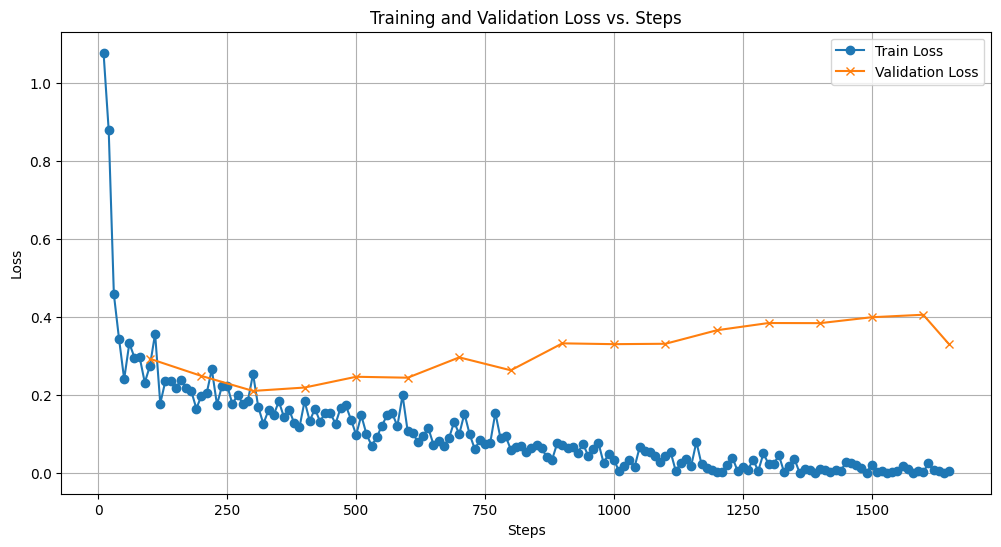

Train-Val Loss Saved!!


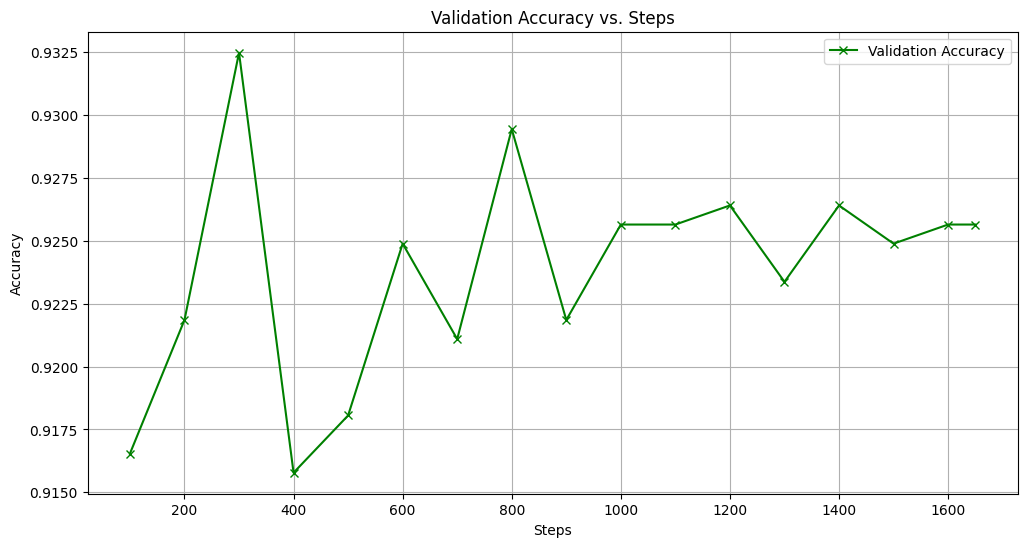

Validation Accuracy Plot Saved!!


In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import os


df_train = pd.read_csv("/kaggle/input/eng-guj/eng_guj_train.csv")
df_val = pd.read_csv("/kaggle/input/eng-guj/eng_guj_val.csv")


unique_labels = df_train['sentiment'].unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
print("Label mapping:", label_mapping)

df_train['sentiment'] = df_train['sentiment'].map(label_mapping)
df_val['sentiment'] = df_val['sentiment'].map(label_mapping)

train_texts = df_train['eng_text'].tolist()
train_labels = df_train['sentiment'].tolist()


val_texts = df_val['eng_text'].tolist()
val_labels = df_val['sentiment'].tolist()


guj_texts = df_val['guj_text'].tolist()
guj_labels = df_val['sentiment'].tolist()


model_name = "ai4bharat/indic-bert" 
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=128
    )


train_dataset = Dataset.from_dict({'text': train_texts, 'labels': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'labels': val_labels})
guj_dataset = Dataset.from_dict({'text': guj_texts, 'labels': guj_labels})


train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
guj_dataset = guj_dataset.map(tokenize_function, batched=True)


train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
guj_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


training_args = TrainingArguments(
    output_dir='/kaggle/working/results/indic_bert_guj',
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy='steps',
    eval_steps=100,
    save_steps=500,
    logging_dir='/kaggle/working/logs/indic_bert_guj',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,  
)


metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


num_labels = len(label_mapping)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


trainer.train()


print("Evaluation on English validation set:")
eval_results = trainer.evaluate()
print(f"Accuracy on English validation set: {eval_results['eval_accuracy']}")


print("Evaluation on Gujarati dataset:")
guj_results = trainer.predict(guj_dataset)
guj_predictions = np.argmax(guj_results.predictions, axis=-1)
guj_accuracy = metric.compute(predictions=guj_predictions, references=guj_results.label_ids)
print(f"Accuracy on Gujarati test data: {guj_accuracy['accuracy']}")


train_logs = trainer.state.log_history

train_loss = [log['loss'] for log in train_logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]
steps = [log['step'] for log in train_logs if 'loss' in log]
eval_steps = [log['step'] for log in train_logs if 'eval_loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in train_logs if 'eval_accuracy' in log]

os.makedirs("/kaggle/working/plots/task3/task3_indic_bert_guj", exist_ok=True)


plt.figure(figsize=(12, 6))
plt.plot(steps, train_loss, label='Train Loss', marker='o')
plt.plot(eval_steps, eval_loss, label='Validation Loss', marker='x')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Steps')
plt.legend()
plt.grid()
plt.savefig("/kaggle/working/plots/task3/task3_indic_bert_guj/training_validation_loss.png")  
plt.show()
print("Train-Val Loss Saved!!")


plt.figure(figsize=(12, 6))
plt.plot(eval_steps, eval_accuracy, label='Validation Accuracy', marker='x', color='green')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Steps')
plt.legend()
plt.grid()
plt.savefig("/kaggle/working/plots/task3/task3_indic_bert_guj/validation_accuracy.png")  # Save the plot
plt.show()
print("Validation Accuracy Plot Saved!!")
